#Carga del modelo

In [ ]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DATASet

In [ ]:
df_train= pd.read_csv('/content/drive/MyDrive/Datasets/HumAID/all_train.csv')
df_test= pd.read_csv('/content/drive/MyDrive/Datasets/HumAID/all_test.csv')
df_dev = pd.read_csv('/content/drive/MyDrive/Datasets/HumAID/all_dev.csv')

df_train.head()

,tweet_id,tweet_text,class_label
0,1031218893908406273,"Kerala Floods: More than 38,000 people rescued...",rescue_volunteering_or_donation_effort
1,1030767523342499842,@BDUTT While PayTm owner Shekhar donated Rs Te...,rescue_volunteering_or_donation_effort
2,1030385981973618688,#KeralaFloods Malayala Manorama makes epaper f...,rescue_volunteering_or_donation_effort
3,1031078567147319297,#KeralaSOS #KeralaFloods Lets centralise all r...,sympathy_and_support
4,1033187418889834497,@narendramodi @AmitShah PS @ kerala is doing t...,rescue_volunteering_or_donation_effort


# Balance de clases
- cortar el dataset a la mas baja o segunda mas baja

In [ ]:
df_train['class_label'].value_counts().sort_values(ascending=True).sum()

np.int64(53516)

In [ ]:
df_test['class_label'].value_counts().sort_values(ascending=True)


,count
class_label,
missing_or_found_people,72
requests_or_urgent_needs,521
displaced_people_and_evacuations,790
caution_and_advice,1070
not_humanitarian,1245
injured_or_dead_people,1447
infrastructure_and_utility_damage,1617
sympathy_and_support,1772
other_relevant_information,2407


#Preprocesamiento
Solo se cambian algunos parametros propios de tweeter pero el modelo es capaz de diferenciar emojis, palabras mal escritas o stop words


In [ ]:
def limpiar_tweet(text):
    # Eliminar URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    # Eliminar menciones (@usuario)
    text = re.sub(r"@\w+", "", text)
    return text

# Aplica la limpieza a la columna 'tweet_text' de los datasets
df_train['tweet_text'] = df_train['tweet_text'].apply(limpiar_tweet)
df_test['tweet_text'] = df_test['tweet_text'].apply(limpiar_tweet)
df_dev['tweet_text'] = df_dev['tweet_text'].apply(limpiar_tweet)

print("Tweet text cleaning applied to df_train and df_test.")
print("Sample of cleaned training data:")
display(df_train[['tweet_text']].head())
print("Sample of cleaned testing data:")
display(df_test[['tweet_text']].head())

Tweet text cleaning applied to df_train and df_test.
Sample of cleaned training data:


,tweet_text
0,"Kerala Floods: More than 38,000 people rescued..."
1,While PayTm owner Shekhar donated Rs Ten Thou...
2,#KeralaFloods Malayala Manorama makes epaper f...
3,#KeralaSOS #KeralaFloods Lets centralise all r...
4,"PS @ kerala is doing the fire fight,lets giv..."


Sample of cleaned testing data:


,tweet_text
0,Please help my uncle and aunt stranded in Kott...
1,Asian Games : Seema Punia to donate 1 lakh rup...
2,Happy Onam to all our sisters&amp;brothers in ...
3,These are the precautions issued by the Direct...
4,RT : . Relief material #KeralaFloodRelief load...


Sampleo de clases

#Experimento
## vamos a usar Robert

In [ ]:
from transformers import AutoTokenizer

# 1. Cargar el Tokenizador
model_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

#2 lista de etiquetas
etiquetas = df_train['class_label'].unique()
id2label = {idx:label for idx, label in enumerate(etiquetas)}
label2id = {label:idx for idx, label in enumerate(etiquetas)}
num_etiquetas = len(etiquetas)
num_etiquetas

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


10

## TOkenizacion

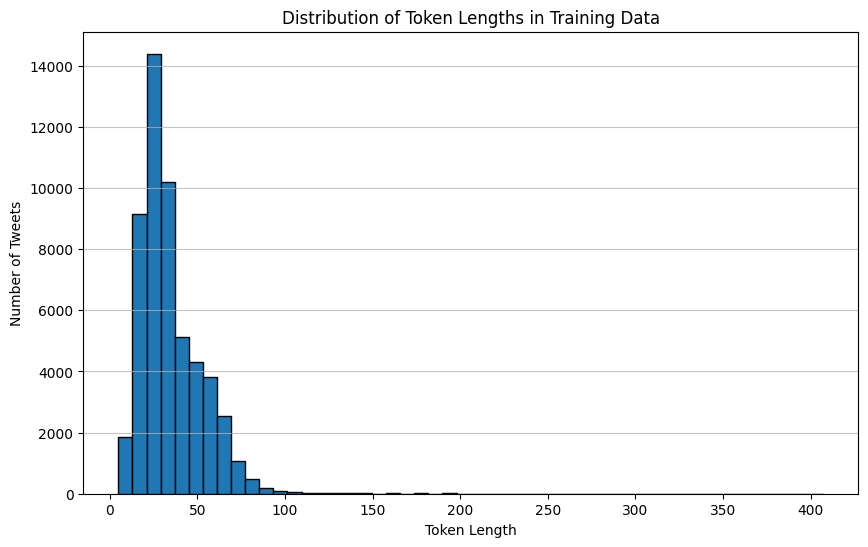

np.float64(67.0)

In [ ]:
#buscar el numero correcto de tokens
def count_tokens(df):
  token_counts = []
  for text in df['tweet_text']:
    tokens = tokenizer(text)
    token_counts.append(len(tokens['input_ids']))
  return token_counts
token_counts_train = count_tokens(df_train)

# hist de distribucion del largo de tokens
plt.figure(figsize=(10, 6))
plt.hist(token_counts_train, bins=50, edgecolor='black')
plt.title('Distribution of Token Lengths in Training Data')
plt.xlabel('Token Length')
plt.ylabel('Number of Tweets')
plt.grid(axis='y', alpha=0.75)
plt.show()

np.quantile(token_counts_train,0.95)

In [ ]:
#tokenizar
def tokenizar(row):
  tokenized_inputs = tokenizer(
      row['tweet_text'],
      truncation=True,
      padding='max_length',
      max_length=64
  )

  # Agregamos la columna labels la cual asigna una categoría a cada texto tokenizado
  tokenized_inputs["labels"] = label2id[row['class_label']]
  return tokenized_inputs

# Aplica la función tokenizar a cada fila del DataFrame
dataset_tokenizado_train = df_train.apply(tokenizar, axis=1)
dataset_tokenizado_test = df_test.apply(tokenizar, axis=1)
dataset_tokenizado_dev = df_dev.apply(tokenizar, axis=1)

print("\nSample of tokenized training data (first entry):")
display(dataset_tokenizado_train.iloc[0])
print("\nSample of tokenized testing data (first entry):")
display(dataset_tokenizado_test.iloc[0])
print("\nSample of tokenized dev data (first entry):")
display(dataset_tokenizado_dev.iloc[0])


Sample of tokenized training data (first entry):


{'input_ids': [0, 530, 45789, 18376, 29, 35, 901, 87, 2843, 6, 151, 82, 8262, 31, 5, 5005, 12, 31410, 911, 11, 14558, 1437, 849, 530, 45789, 16197, 5715, 29, 849, 530, 45789, 16197, 5715, 29806, 14134, 849, 530, 45789, 849, 16197, 5715, 849, 530, 45789, 23074, 849, 25767, 41810, 849, 4862, 857, 34886, 45789, 849, 4825, 5715, 154, 849, 9325, 30558, 849, 487, 1322, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 0}


Sample of tokenized testing data (first entry):


{'input_ids': [0, 6715, 244, 127, 11992, 8, 15845, 13202, 11, 229, 5229, 271, 3432, 718, 34731, 5408, 234, 20559, 6, 16744, 1115, 4987, 1999, 6, 248, 28867, 6, 221, 15322, 424, 212, 32154, 4, 8801, 30, 4293, 50, 7324, 5131, 4, 3401, 458, 8, 2504, 4, 849, 530, 45789, 16197, 5715, 29, 849, 530, 45789, 16197, 5715, 29, 2464, 849, 330, 6653, 5347, 35249, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 2}


Sample of tokenized dev data (first entry):


{'input_ids': [0, 13963, 4832, 849, 20441, 7, 5042, 112, 153, 1404, 13, 14558, 21164, 1364, 4557, 1437, 849, 530, 45789, 16197, 5715, 29, 849, 41008, 46002, 530, 45789, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}

# Configuración del modelo

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score

#cargamos el modelo : se carga destilbert con una cabeza de clasificacion aleatoria de 10 salidas
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_etiquetas,
    id2label=id2label, # Opcional: guarda los mapeos en el modelo
    label2id=label2id
)

#argumentos del entrenamiento: parametros para el fine-tuning
training_args = TrainingArguments(
    output_dir="resultados-distilbert-desastres",

    # --- Hiperparámetros de Fine-Tuning ---
    learning_rate=2e-5, # Tasa de aprendizaje baja, estándar para fine-tuning
    num_train_epochs=3, # 3-5 épocas suele ser suficiente para BERT/DistilBERT
    per_device_train_batch_size=16, # Ajustar (a 8 o 32) según la VRAM de Colab
    per_device_eval_batch_size=16,
    weight_decay=0.01, # Regularización [24, 25]


    # --- Gestión del Entrenamiento ---
    eval_strategy="epoch", # Evaluar al final de cada época
    save_strategy="epoch", # Guardar al final de cada época
    load_best_model_at_end=True, # Cargar el mejor modelo al final
    metric_for_best_model="f1_macro", # Métrica clave para problemas desbalanceados
    fp16=False, # Usar precisión mixta, acelera el entrenamiento en Colab
)

#funcion metrica (requerida por el trainer), quiza es mejor cambiar las metricas??
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) # Convertir logits a predicciones

    # Usar F1-macro: es crucial para clasificación multiclase desbalanceada
    # (trata a todas las clases por igual, sin importar su tamaño)
    f1 = f1_score(labels, predictions, average="macro")
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "f1_macro": f1,
    }

#trainer:
train_dataset_list = dataset_tokenizado_train.tolist()
eval_dataset_list = dataset_tokenizado_dev.tolist()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_list,
    eval_dataset=eval_dataset_list,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entrenar el modelo

In [ ]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bastian-c-silva (bastian-c-silva-university-of-chile) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.639300,0.646509,0.769606,0.741027
2,0.544100,0.611469,0.784238,0.764282
3,0.421000,0.634480,0.780901,0.766973


TrainOutput(global_step=10035, training_loss=0.5705028779125356, metrics={'train_runtime': 2125.0682, 'train_samples_per_second': 75.55, 'train_steps_per_second': 4.722, 'total_flos': 5280623487949824.0, 'train_loss': 0.5705028779125356, 'epoch': 3.0})

Matriz de confusion con el desempeño del modelo

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# 1. Generar Matriz de Confusión para ver los errores
predictions = trainer.predict(dataset_tokenizado_test)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = dataset_tokenizado_test.apply(lambda x: x['labels'])


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from sklearn.metrics import classification_report, confusion_matrix


def evaluar_modelo(y_true, y_pred, df, etiquetas, nombre_modelo="modelo"):
    """
    Evalúa el modelo y genera visualizaciones mejoradas.

    Args:
        y_true: Etiquetas verdaderas
        y_pred: Predicciones del modelo
        df: DataFrame original con los datos
        etiquetas: Lista ordenada de etiquetas
        nombre_modelo: Nombre para guardar las gráficas
    """
    # Obtener clases ordenadas desde el DataFrame original
    class_labels = sorted(df['class_label'].unique())

    # Crear classification report como diccionario
    report_dict = classification_report(
        y_true,
        y_pred,
        output_dict=True,
        digits=3
    )

    # Formato de la tabla
    def format_label(label, max_width=15):
        # Incluir nombre_modelo en la etiqueta formateada
        formatted = f"{label.replace('_', ' ')}"
        return '\n'.join(textwrap.wrap(formatted, max_width))

    formatted_etiquetas = [format_label(label) for label in etiquetas]

    # Convertir a DataFrame y eliminar support
    df_report = pd.DataFrame(report_dict).T.drop(columns=['support'])

    # Excluir accuracy, macro avg y weighted avg
    df_classes = df_report.iloc[:-3]

    # Gráfico del F1-score por clase
    plt.figure(figsize=(10, 8))
    df_classes['f1-score'].plot(kind='barh', color='skyblue')

    plt.xlabel("F1-score", fontsize=12)
    plt.ylabel("Clases", fontsize=12)
    plt.title(f"F1-score por clase - {nombre_modelo}", fontsize=14)
    plt.xlim(0, 1)
    plt.gca().invert_yaxis()
    plt.gca().set_yticklabels(formatted_etiquetas) # Set y-axis labels using formatted_etiquetas

    for i, v in enumerate(df_classes['f1-score']):
        plt.text(v + 0.01, i, f"{v:.3f}", va='center')

    plt.tight_layout()
    plt.savefig(f"f1score_{nombre_modelo}.png")
    plt.show()

    # Matriz de confusión normalizada
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_etiquetas)))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12,10))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", xticklabels=formatted_etiquetas, yticklabels=formatted_etiquetas, cmap='Blues')
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(f"Matriz de confusión normalizada - {nombre_modelo}")
    plt.tight_layout()
    plt.savefig(f"matriz_confusion_{nombre_modelo}.png")
    plt.show()

    # Imprimir el reporte de clasificación
    print(f"\n{'='*80}")
    print(f"Classification Report - {nombre_modelo}")
    print('='*80)
    print(df_report.to_string())
    print('='*80)

print("✅ Función evaluar_modelo definida correctamente")

✅ Función evaluar_modelo definida correctamente


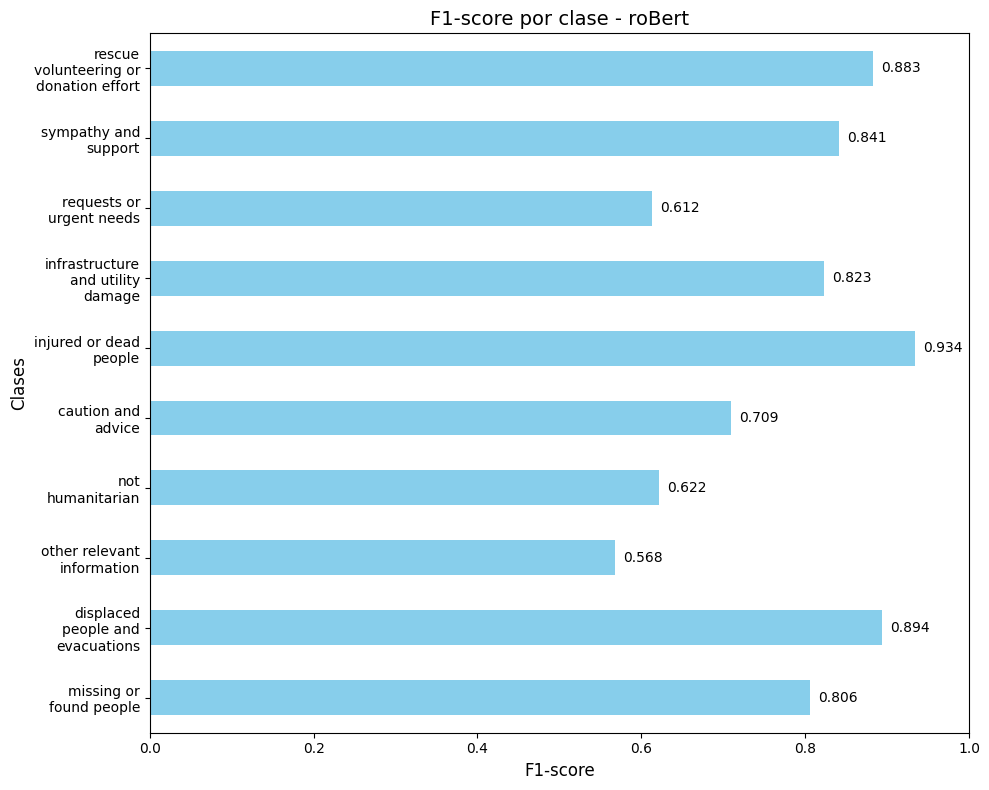

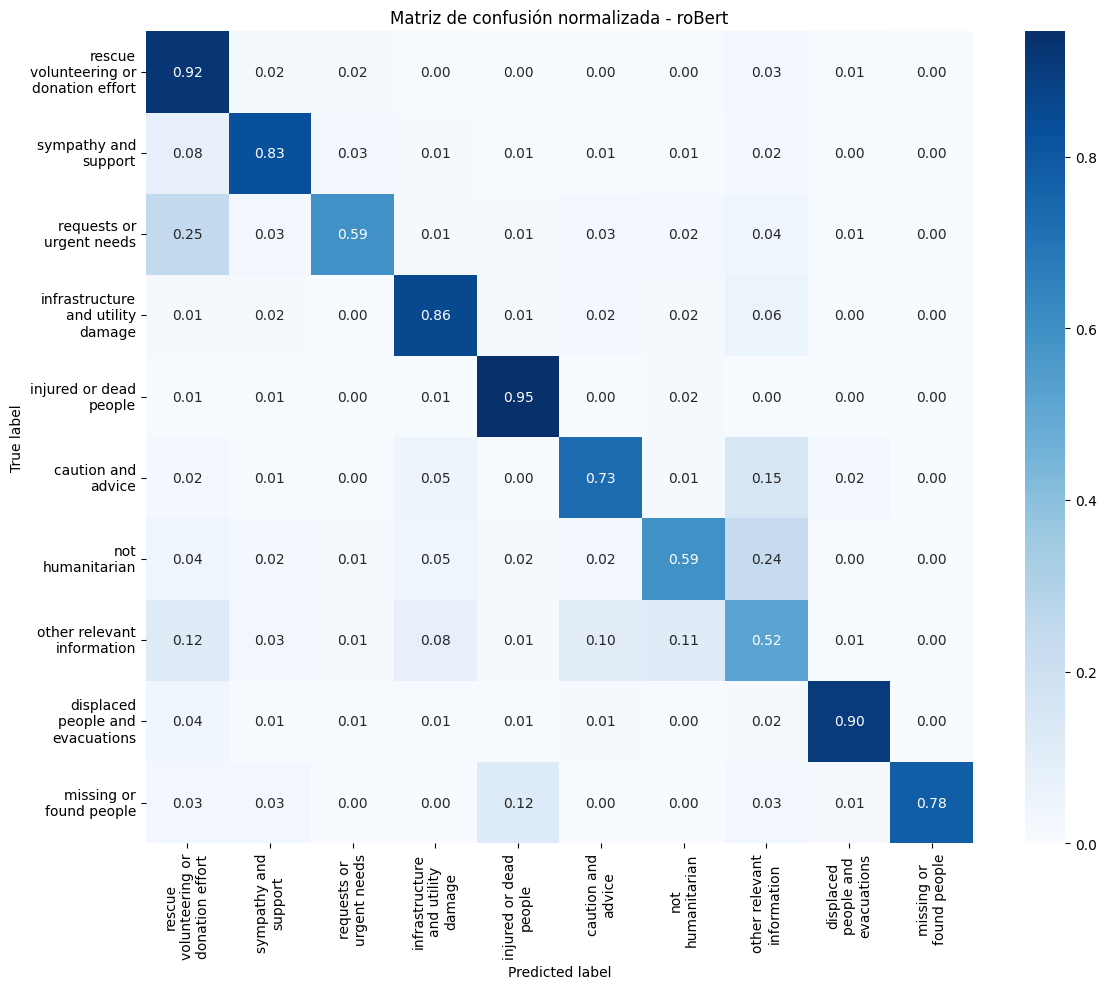


Classification Report - roBert
              precision    recall  f1-score
0              0.848154  0.920341  0.882774
1              0.855394  0.827878  0.841411
2              0.633197  0.593090  0.612488
3              0.788996  0.860235  0.823077
4              0.921265  0.946095  0.933515
5              0.692513  0.726168  0.708942
6              0.653404  0.593574  0.622054
7              0.625375  0.520150  0.567929
8              0.883663  0.903797  0.893617
9              0.835821  0.777778  0.805755
accuracy       0.788706  0.788706  0.788706
macro avg      0.773778  0.766911  0.769156
weighted avg   0.781718  0.788706  0.783649


In [ ]:
evaluar_modelo(
    y_true=y_true,
    y_pred=y_pred,
    df=df_train,
    etiquetas=etiquetas,
    nombre_modelo="roBert"
)